In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import tensorflow as tf 
from keras import layers

In [63]:
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,InputLayer
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [64]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

C:\Users\Eugen\.conda\envs\GPU\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


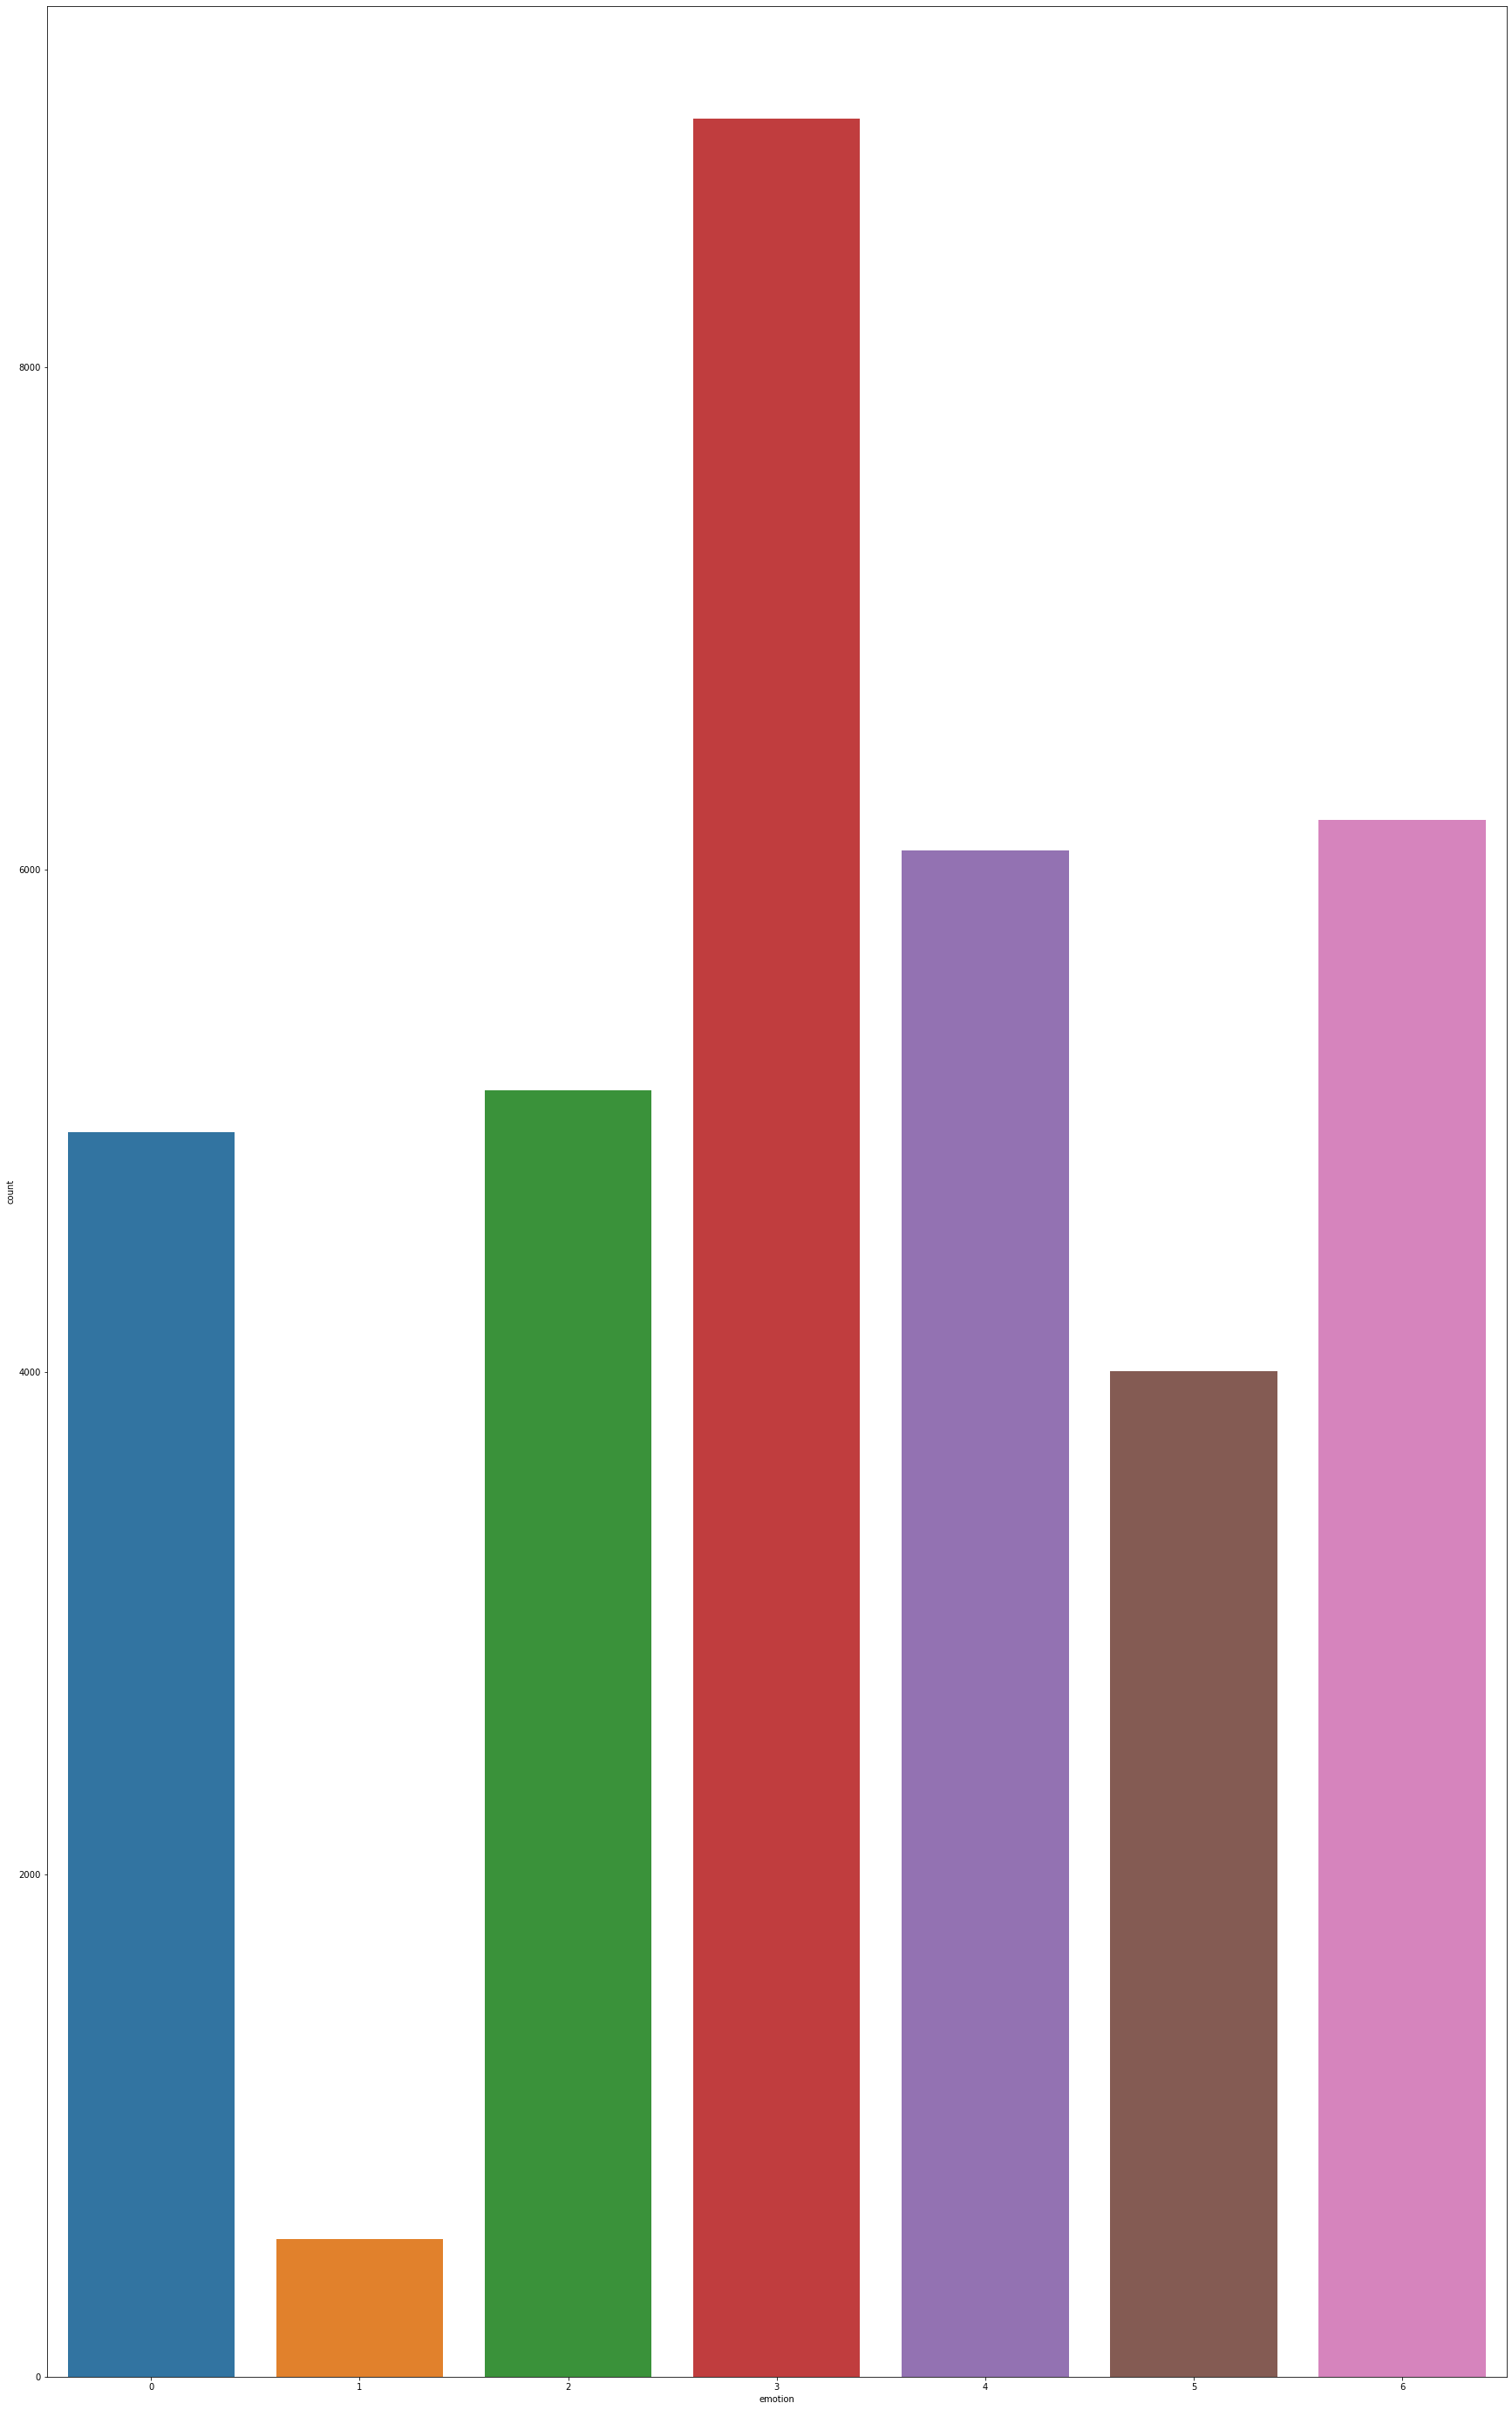

In [65]:
df.emotion.unique()
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()
sns.countplot(df.emotion)
pyplot.show()

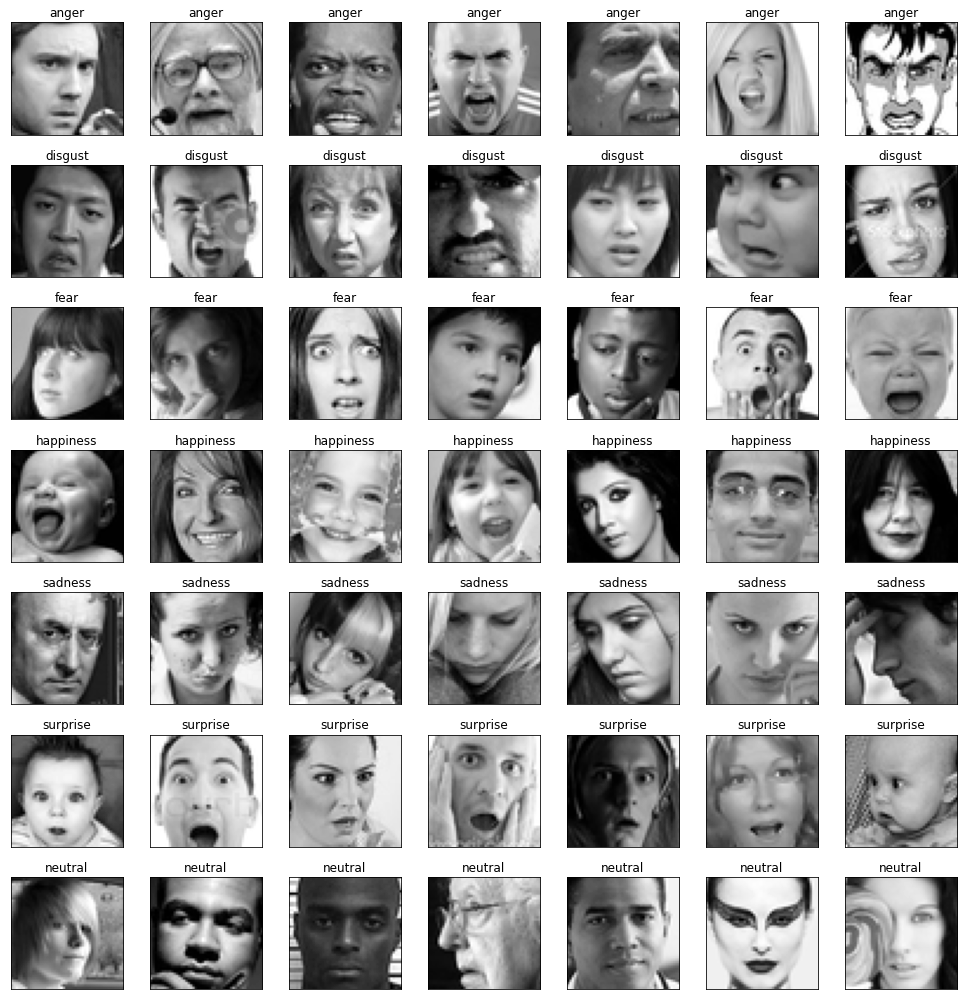

In [66]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [72]:
INTERESTED_LABELS = [3, 4, 6]
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape # (21264, 3)

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)

In [73]:
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [74]:
input_shape = [48,48,1]
batch_size = 32
model = Sequential(name='DCNN')
# model.add(
#     InputLayer(
#         input_shape = (img_width,img_height,img_depth)
#     )
# )
model.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        input_shape=(img_width, img_height, img_depth),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model.add(BatchNormalization(name='b1'))
model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model.add(BatchNormalization(name='b2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(
    Conv2D(
        filters=64,
        kernel_size=(3,7),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model.add(BatchNormalization(name='batchnorm_3'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.3, name='dropout_3'))

model.add(
    Conv2D(
        filters=128,
        kernel_size=(2,2),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_6'))    
model.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model.add(BatchNormalization(name='b7'))
model.add(Flatten(name='flatten'))
model.add(
    Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )
)

model.compile(
    loss='categorical_crossentropy',
    optimizer="Adam",
    metrics=['accuracy']
)
    
#model.summary()

In [75]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [76]:
epochs = 15
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,  validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size)


Epoch 1/15
598/598 [==============================] - 17s 26ms/step - loss: 1.3363 - accuracy: 0.4208 - val_loss: 1.2220 - val_accuracy: 0.4739
Epoch 2/15
598/598 [==============================] - 16s 26ms/step - loss: 1.1197 - accuracy: 0.4920 - val_loss: 0.8902 - val_accuracy: 0.5867
Epoch 3/15
598/598 [==============================] - 15s 25ms/step - loss: 0.9647 - accuracy: 0.5647 - val_loss: 0.9572 - val_accuracy: 0.5919
Epoch 4/15
598/598 [==============================] - 15s 25ms/step - loss: 0.8720 - accuracy: 0.5957 - val_loss: 1.0853 - val_accuracy: 0.6159
Epoch 5/15
598/598 [==============================] - 15s 25ms/step - loss: 0.8083 - accuracy: 0.6264 - val_loss: 0.6903 - val_accuracy: 0.6972
Epoch 6/15
598/598 [==============================] - 15s 25ms/step - loss: 0.7710 - accuracy: 0.6476 - val_loss: 0.6901 - val_accuracy: 0.7057
Epoch 7/15
598/598 [==============================] - 16s 26ms/step - loss: 0.7348 - accuracy: 0.6637 - val_loss: 0.7778 - val_accuracy:

In [77]:
score = model.evaluate(X_valid, y_valid)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

67/67 [==============================] - 1s 12ms/step - loss: 0.5849 - accuracy: 0.7536
Test loss: 0.5848608016967773
Test accuracy: 0.7536436319351196


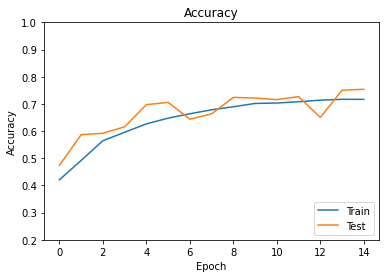

In [78]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim(0.2, 1)
plt.rcParams['figure.figsize'] = [30, 50]
plt.show()

In [79]:
model.save("model.h5")
from tensorflow import keras
model = keras.models.load_model("model.h5")

In [101]:
df = pd.read_csv('fer2013.csv')
INTERESTED_LABELS = [0,2,5]
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape # (21264, 3)



(14076, 3)

In [103]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)



(14076, 48, 48, 1)

In [104]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)

In [105]:
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

input_shape = [48,48,1]
batch_size = 32
model1 = Sequential(name='DCNN')
# model.add(
#     InputLayer(
#         input_shape = (img_width,img_height,img_depth)
#     )
# )
model1.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        input_shape=(img_width, img_height, img_depth),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model1.add(BatchNormalization(name='b1'))
model1.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model1.add(BatchNormalization(name='b2'))
model1.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model1.add(
    Conv2D(
        filters=64,
        kernel_size=(3,7),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model1.add(BatchNormalization(name='batchnorm_3'))

model1.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model1.add(Dropout(0.3, name='dropout_3'))

model1.add(
    Conv2D(
        filters=128,
        kernel_size=(2,2),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)

model1.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_6'))    
model1.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model1.add(BatchNormalization(name='b7'))
model1.add(Flatten(name='flatten'))
model1.add(
    Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )
)

model1.compile(
    loss='categorical_crossentropy',
    optimizer="Adam",
    metrics=['accuracy']
)
    

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [107]:
epochs = 19
history = model1.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,  validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size)


Epoch 1/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7713 - accuracy: 0.6419 - val_loss: 0.7140 - val_accuracy: 0.6726
Epoch 2/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7580 - accuracy: 0.6531 - val_loss: 0.7478 - val_accuracy: 0.6605
Epoch 3/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7575 - accuracy: 0.6493 - val_loss: 0.7202 - val_accuracy: 0.6641
Epoch 4/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7491 - accuracy: 0.6519 - val_loss: 0.6917 - val_accuracy: 0.6939
Epoch 5/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7380 - accuracy: 0.6583 - val_loss: 0.8093 - val_accuracy: 0.6520
Epoch 6/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7342 - accuracy: 0.6680 - val_loss: 0.7021 - val_accuracy: 0.6875
Epoch 7/20
395/395 [==============================] - 10s 25ms/step - loss: 0.7296 - accuracy: 0.6644 - val_loss: 0.7137 - val_accuracy: